In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

import nbimporter
from tfidf import LyricsTFIDF

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

Importing Jupyter notebook from tfidf.ipynb


In [33]:
%run utils.ipynb

# LyricsClustering CLASS 

In [55]:
class LyricsClustering():
    
    
    def __init__(self, lyrics_df, preprocessed_corpus):
        
        self.lyrics_df = lyrics_df
        self.preprocessed_corpus = preprocessed_corpus
        self.tfidf_model = LyricsTFIDF(lyrics_df, preprocessed_corpus)
        self.tfidf_matrix_reduced = None
        
        
    def tfidf_matrix(self, preprocessed_corpus=None, ngram_range=(1,1), **kwargs):
        
        tfidf_dataframe = self.tfidf_model.fit_transform(preprocessed_corpus=preprocessed_corpus, ngram_range=ngram_range, **kwargs)
        
        return self.tfidf_model.tfidf_matrix
    
    
    def reduce_dimensionality(self, method, num_components, tfidf_matrix):
                
        # returns U,S,V if 'svd' or W, H if 'nmf'
        blocks = self.tfidf_model.matrix_factorization(method, num_components, tfidf_matrix)
        self.tfidf_matrix_reduced = blocks[0]
        
        return blocks[0]
        
    
    def guess_num_clusters(self, tfidf_matrix_reduced, sample_size=15000):
        
        # Use agglomerative clustering to guess a likely number of cluster present in the data
        sample = np.random.choice(tfidf_matrix_reduced.shape[0], replace=False, size=sample_size)
        linkage_matrix = linkage(tfidf_matrix_reduced[sample], method='ward')

        row_dendrogram = dendrogram(linkage_matrix)
        plt.tight_layout()
        plt.ylabel('Euclidean distance')
        plt.show()
    
    
    def find_centroids(self, num_clusters, tfidf_matrix_reduced, sample_size=15000):
            
        # clustering on a subset of whole data
        agg = AgglomerativeClustering(n_clusters=num_clusters)
        sample = np.random.choice(tfidf_matrix_reduced.shape[0], replace=False, size=sample_size)
        agg_sample_ids = agg.fit_predict(tfidf_matrix_reduced[sample])     
        
        # find centroids
        centroids = np.array([tfidf_matrix_reduced[sample][agg_sample_ids == cluster].mean(axis=0) 
                              for cluster in range(num_clusters)])
        return centroids
    
    
    def k_means_clustering(self, num_clusters, centroids, tfidf_matrix_reduced):
        
        km = KMeans(n_clusters=num_clusters, n_jobs=-1, init=centroids)

        # fit
        km.fit(tfidf_matrix_reduced)
        
        self.k_means_model = km
        
    
    def plot_clusters(self, tfidf_matrix_3d, cluster_labels, dimensions=3, view_init=(0,0), fig_size=(10, 10)):
        
        plot_vectors(tfidf_matrix_3d, labels=cluster_labels, dimensions=dimensions, view_init=view_init, fig_size=fig_size)
    
    
    def silhouette_scores(self, num_cluster_range, tfidf_matrix, sample_size, fig_size=(20, 10)):

        silhouettes = []
        
        print(f"Evaluating clusters in range {num_cluster_range} ...", flush=True)
        for c in tqdm(range(*num_cluster_range)):
            agg_clustering = AgglomerativeClustering(n_clusters=c)
            sample = np.random.choice(tfidf_matrix.shape[0], replace=False, size=sample_size)
            agg_cluster_ids = agg_clustering.fit_predict(tfidf_matrix[sample])

            score = silhouette_score(tfidf_matrix[sample], agg_cluster_ids)
            silhouettes.append(score)

        fig, ax = plt.subplots(figsize=fig_size)
        plt.plot(range(*num_cluster_range), silhouettes, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Silhouette score')
        plt.title('Silhouette Method For Optimal k')
        plt.show()
        

## Analysis 

In [56]:
lyrics_cleaned = pd.read_csv("./data/lyrics_cleaned.csv")

In [57]:
with open('./data/trimmed_corpus.pickle', 'rb') as pickled_object:
    trimmed_corpus = pickle.load(pickled_object)

In [58]:
lyrics_clustering = LyricsClustering(lyrics_cleaned, trimmed_corpus)

In [59]:
tfidf_matrix = lyrics_clustering.tfidf_matrix(trimmed_corpus, ngram_range=(1, 3))
tfidf_matrix.shape

Joining tokens for each lyrics ...


100%|██████████| 43844/43844 [00:00<00:00, 226244.95it/s]

Fitting TFIDF vectorizer ...


(43844, 11055)

In [60]:
tfidf_matrix_reduced = lyrics_clustering.reduce_dimensionality(method='svd', num_components=500, tfidf_matrix=tfidf_matrix)
tfidf_matrix_reduced.shape

(43844, 500)

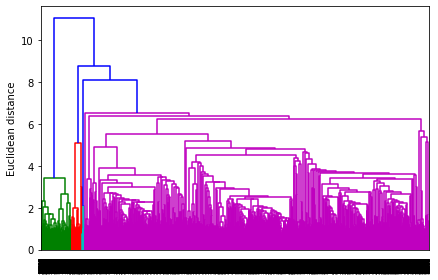

In [6]:
lyrics_clustering.guess_num_clusters(tfidf_matrix_reduced, sample_size=20000, reduction_components=500)

Evaluating clusters in range (2, 10) ...


100%|██████████| 8/8 [02:51<00:00, 21.46s/it]


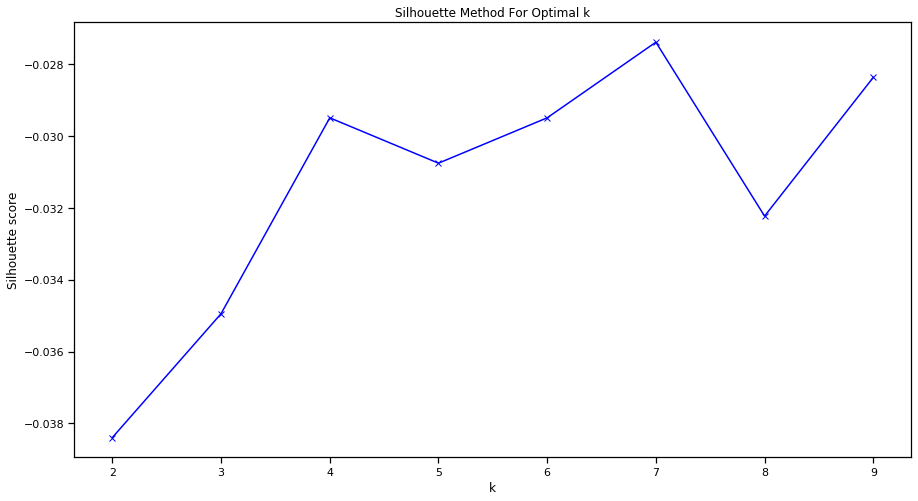

In [9]:
lyrics_clustering.silhouette_scores(num_cluster_range=(2, 10), tfidf_matrix=tfidf_matrix_reduced, 
                                    sample_size=8000, fig_size=(15, 8))

In [61]:
centroids = lyrics_clustering.find_centroids(num_clusters=7, tfidf_matrix_reduced=tfidf_matrix_reduced, sample_size=20000)

In [62]:
centroids.shape

(7, 500)

In [63]:
lyrics_clustering.k_means_clustering(num_clusters=7, centroids=centroids, tfidf_matrix_reduced=tfidf_matrix_reduced)

/Users/lucamasserano/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [64]:
cluster_labels = lyrics_clustering.k_means_model.labels_
cluster_labels.shape

(43844,)

In [16]:
tfidf_matrix_3d = lyrics_clustering.reduce_dimensionality(method='svd', num_components=3, tfidf_matrix=tfidf_matrix_reduced)
tfidf_matrix_3d.shape

(43844, 3)

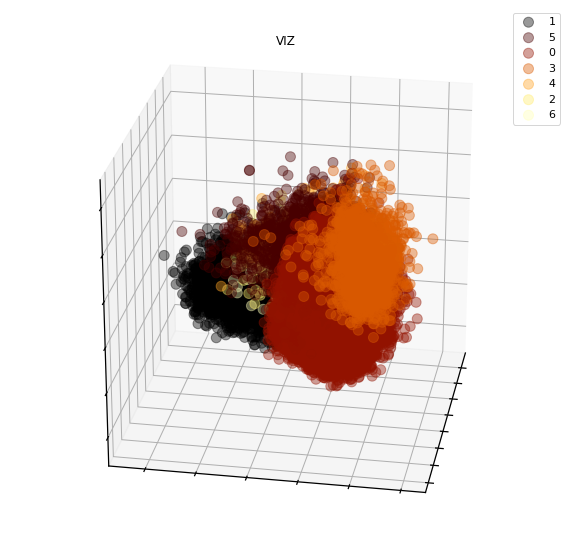

In [77]:
lyrics_clustering.plot_clusters(tfidf_matrix_3d, cluster_labels, view_init=(25, 190), fig_size=(10, 10))

## Analysis of resulting clusters

In [65]:
def year_to_period(year):
    if int(year) < 1970:
        return "<70s"
    elif int(year) < 1980:
        return "70s-80s"
    elif int(year) < 1990:
        return "80s-90s"
    elif int(year) < 2000:
        return "90s-2000"
    elif int(year) < 2010:
        return "2000-2010"
    else:
        return ">=2010"
        
lyrics_cleaned.loc[:, "period"] = lyrics_cleaned.year.apply(lambda year: year_to_period(year))

### Cluster sizes

In [85]:
for i in range(np.unique(cluster_labels).shape[0]):
    print(f'cluster n.{i} has size {len(np.array(lyrics_clustering.preprocessed_corpus)[lyrics_cleaned.loc[cluster_labels == i, :].index].tolist())}')

cluster n.0 has size 34051
cluster n.1 has size 5105
cluster n.2 has size 628
cluster n.3 has size 1416
cluster n.4 has size 564
cluster n.5 has size 1754
cluster n.6 has size 326


In [96]:
for i in range(np.unique(cluster_labels).shape[0]):
    cluster_df = lyrics_cleaned.loc[cluster_labels == i, :]
    genre_distribution = [(period, cluster_df.loc[cluster_df.period == period, :].shape[0]) for period in cluster_df.period.unique()]
    print(f'cluster n.{i} period distribution: {genre_distribution}', '\n')

cluster n.0 period distribution: [('>=2010', 12414), ('2000-2010', 7646), ('90s-2000', 4968), ('80s-90s', 3675), ('70s-80s', 3005), ('<70s', 2343)] 

cluster n.1 period distribution: [('>=2010', 3288), ('2000-2010', 1130), ('90s-2000', 585), ('70s-80s', 30), ('80s-90s', 60), ('<70s', 12)] 

cluster n.2 period distribution: [('>=2010', 249), ('90s-2000', 87), ('2000-2010', 142), ('80s-90s', 58), ('70s-80s', 46), ('<70s', 46)] 

cluster n.3 period distribution: [('2000-2010', 290), ('>=2010', 565), ('90s-2000', 196), ('80s-90s', 151), ('70s-80s', 121), ('<70s', 93)] 

cluster n.4 period distribution: [('2000-2010', 100), ('>=2010', 319), ('90s-2000', 43), ('80s-90s', 35), ('70s-80s', 61), ('<70s', 6)] 

cluster n.5 period distribution: [('>=2010', 861), ('2000-2010', 402), ('90s-2000', 209), ('80s-90s', 133), ('70s-80s', 106), ('<70s', 43)] 

cluster n.6 period distribution: [('>=2010', 165), ('2000-2010', 77), ('70s-80s', 27), ('80s-90s', 21), ('<70s', 18), ('90s-2000', 18)] 



In [89]:
cluster_corpus = np.array(lyrics_clustering.preprocessed_corpus)[
                lyrics_cleaned.loc[cluster_labels == 4, :].index
                ].tolist()
tfidf_cluster = lyrics_clustering.tfidf_model.fit_transform(preprocessed_corpus=cluster_corpus,
                                                             save_attributes=False, ngram_range=(1,3), topn=30)
tfidf_cluster

Joining tokens for each lyrics ...


100%|██████████| 564/564 [00:00<00:00, 142599.76it/s]

Fitting TFIDF vectorizer ...


,ngram,tfidf
0,know,9.763076
1,love,9.548345
2,yeah,8.951818
3,just,8.062687
4,say,7.863989
5,baby,7.792373
6,make,7.182333
7,come,7.046862
8,time,6.725336
9,want,6.706284


### Cluster 1

In [78]:
cluster1_corpus = np.array(lyrics_clustering.preprocessed_corpus)[
                lyrics_cleaned.loc[cluster_labels == 1, :].index
                ].tolist()
len(cluster1_corpus)

5105

### Cluster 2

In [79]:
cluster2_corpus = np.array(lyrics_clustering.preprocessed_corpus)[
                lyrics_cleaned.loc[cluster_labels == 2, :].index
                ].tolist()
len(cluster2_corpus)

628

### Cluster 3

In [80]:
cluster3_corpus = np.array(lyrics_clustering.preprocessed_corpus)[
                lyrics_cleaned.loc[cluster_labels == 3, :].index
                ].tolist()
len(cluster3_corpus)

1416

### Cluster 4

In [81]:
cluster4_corpus = np.array(lyrics_clustering.preprocessed_corpus)[
                lyrics_cleaned.loc[cluster_labels == 4, :].index
                ].tolist()
len(cluster4_corpus)

564